In [1]:
import os
import re

import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
import seaborn as sns
import torch
import tifffile
import yaml
from torchio.transforms import Resize
from einops import rearrange

import napari

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
from mushroom.mushroom_v3 import Mushroom

/Users/erikstorrs/miniconda3/envs/mushroom-dev/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/erikstorrs/miniconda3/envs/mushroom-dev/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/erikstorrs/miniconda3/envs/mushroom-dev

In [5]:
import mushroom.visualization.viewer as viewer
from mushroom.visualization.napari import display_napari

In [6]:
output_dir = '/Users/erikstorrs/Documents/ding/mushroom/data/subclone/HT397B1/outputs'
config_filepath = os.path.join(output_dir, 'mushroom_config_local.yaml')
outputs_filepath = os.path.join(output_dir, 'outputs.pt')

In [7]:
data = torch.load(outputs_filepath)
data.keys()

dict_keys(['recon_embs', 'recon_imgs', 'true_imgs', 'cluster_distances', 'cluster_distance_volume', 'cluster_centroids', 'cluster_ids'])

In [8]:
for k, v in data.items():
    print(k, v.shape)

recon_embs torch.Size([2, 256, 60, 60])
recon_imgs torch.Size([2, 11622, 60, 60])
true_imgs torch.Size([2, 11622, 60, 60])
cluster_distances torch.Size([2, 60, 60, 20])
cluster_distance_volume torch.Size([200, 60, 60, 20])
cluster_centroids torch.Size([20, 256])
cluster_ids torch.Size([2, 60, 60])


In [9]:
config = yaml.safe_load(open(config_filepath))
sections = config['sections']
sections

[{'data': [{'dtype': 'visium',
    'filepath': '/Users/erikstorrs/Documents/ding/mushroom/data/subclone/HT397B1/registered/s0_visium_processed.h5ad'}],
  'id': 's0',
  'position': 0},
 {'data': [{'dtype': 'multiplex',
    'filepath': '/Users/erikstorrs/Documents/ding/mushroom/data/subclone/HT397B1/registered/s1_multiplex.ome.tiff'}],
  'id': 's1',
  'position': 5},
 {'data': [{'dtype': 'multiplex',
    'filepath': '/Users/erikstorrs/Documents/ding/mushroom/data/subclone/HT397B1/registered/s2_multiplex.ome.tiff'}],
  'id': 's2',
  'position': 55},
 {'data': [{'dtype': 'visium',
    'filepath': '/Users/erikstorrs/Documents/ding/mushroom/data/subclone/HT397B1/registered/s3_visium_processed.h5ad'}],
  'id': 's3',
  'position': 100},
 {'data': [{'dtype': 'multiplex',
    'filepath': '/Users/erikstorrs/Documents/ding/mushroom/data/subclone/HT397B1/registered/s4_multiplex.ome.tiff'}],
  'id': 's4',
  'position': 105},
 {'data': [{'dtype': 'multiplex',
    'filepath': '/Users/erikstorrs/Docume

In [12]:
obj = viewer.MushroomViewer(config, data, downsample=.5)

In [15]:
dtype_to_marker = {
    'visium': ['EPCAM', 'CD8A', 'IL7R'],
    'multiplex': ['Pan-Cytokeratin', 'CD8']
}

napari_args_list = obj.get_sections(dtype_to_marker=dtype_to_marker)

In [16]:
# napari_args_list[3]

In [17]:
viewer = display_napari(napari_args_list, obj.volume)
napari.run()

[NapariImageArgs(name='he_s0', position=0, dtype='he', scale_factor=0.5, channels=None, img=array([[[ 46,  36,  21, ...,  36,  46,  41],
         [ 72,  37,  23, ...,  45,  49,  49],
         [ 56,  29,  31, ...,  51,  63,  60],
         ...,
         [ 67,  55,  72, ...,  81, 104,  79],
         [ 31,  51,  48, ...,  29,  44,  64],
         [ 33,  44,  43, ...,  26,  43,  52]]], dtype=uint8), spots=None),
 NapariImageArgs(name='he_s3', position=11, dtype='he', scale_factor=0.5, channels=None, img=array([[[62, 37, 42, ..., 78, 93, 71],
         [28, 41, 61, ..., 74, 84, 82],
         [44, 65, 75, ..., 64, 76, 97],
         ...,
         [52, 53, 69, ..., 44, 31, 38],
         [62, 68, 77, ..., 38, 25, 16],
         [68, 66, 60, ..., 25, 17, 10]]], dtype=uint8), spots=None),
 NapariImageArgs(name='visium_s0', position=0, dtype='visium', scale_factor=0.4918032786885246, channels=['EPCAM'], img=array([[[54, 54, 54, ..., 80, 80, 80],
         [54, 54, 54, ..., 80, 80, 80],
         [54, 54

In [18]:
obj.get_sections()

TypeError: 'method' object is not subscriptable

In [67]:
import skimage

In [71]:
data = viewer.layers[19].data
data.shape

(17, 960, 960)

In [81]:
# Use marching cubes to obtain the surface mesh of these ellipsoids
volume = np.asarray(obj.volume)
vertices, faces, normals, values = skimage.measure.marching_cubes(data, 40, step_size=5)

In [78]:
values

array([6., 5., 4., ..., 3., 3., 4.], dtype=float32)

In [82]:
# values = np.linspace(0, 1, len(vertices))

surface = (vertices, faces, values)

viewer = napari.view_surface(surface)  # add the surface

In [75]:
vertices = np.array([[0, 0], [0, 20], [10, 0], [10, 10]])
faces = np.array([[0, 1, 2], [1, 2, 3]])
values = np.linspace(0, 1, len(vertices))
surface = (vertices, faces, values)

viewer = napari.view_surface(surface)  # add the surface

In [55]:
layer = viewer.layers[0]
layer

<Image layer 'cluster 0' at 0x3931b5490>

In [56]:
layer.data.shape

(17, 960, 960)

In [66]:
layer.experimental_clipping_planes

[]

In [27]:
from mushroom.visualization.napari import to_uint8

In [31]:
volume = obj.volume.max() - obj.volume
volume = to_uint8(volume)
volume.shape

(20, 17, 960, 960)

In [33]:
volume.mean(axis=(1,2,3))

array([100.79606592, 102.55868483, 101.838717  , 101.60108507,
        91.69741039,  88.65454433, 104.88467084, 100.44085593,
        99.50361245, 103.23097631,  83.23634772, 104.31251666,
        96.8032164 ,  81.83422635,  87.43895361,  96.21299811,
        98.45984164, 105.38283171, 102.9230329 ,  97.19070664])

In [ ]:
pct = .99
pct = 

In [38]:
obj.volume.shape

torch.Size([20, 17, 960, 960])

In [39]:
probs = torch.nn.functional.softmax(obj.volume, dim=0)
probs.shape

torch.Size([20, 17, 960, 960])

/Users/erikstorrs/miniconda3/envs/mushroom-dev/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


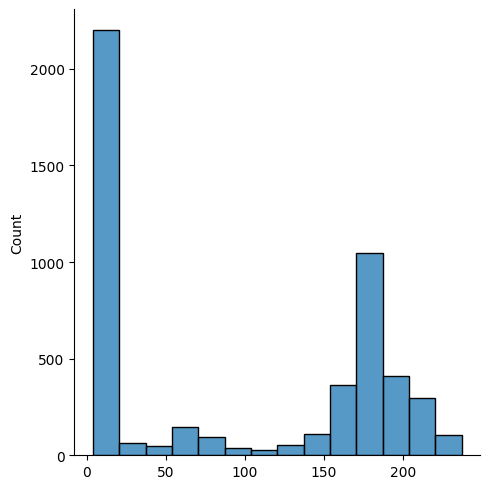

In [35]:
sns.displot(np.random.choice(volume[19].flatten(), size=5000))

/Users/erikstorrs/miniconda3/envs/mushroom-dev/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


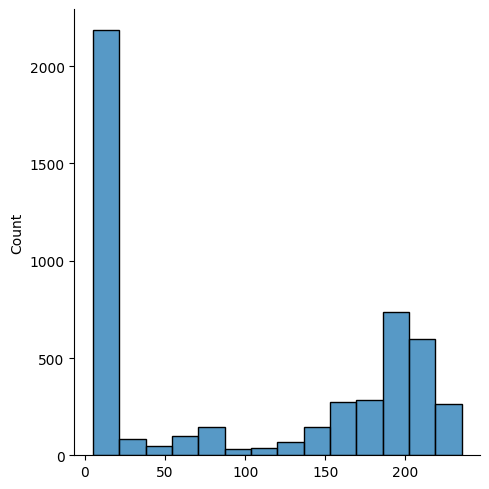

In [36]:
sns.displot(np.random.choice(volume[18].flatten(), size=5000))

/Users/erikstorrs/miniconda3/envs/mushroom-dev/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


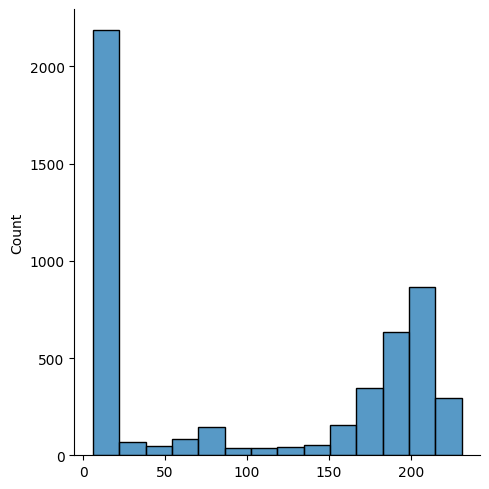

In [37]:
sns.displot(np.random.choice(volume[17].flatten(), size=5000))

In [ ]:
pct = .99
pc